In [1]:
from picamera.array import PiYUVArray, PiRGBArray
from picamera import PiCamera

from scipy.signal import find_peaks, butter, filtfilt

import time
import matplotlib.pyplot as plt
import skimage as ski
import numpy as np

# Camera resolution
res = (640, 480)

CAMERA_CENTER = res[0] // 2
CAMERA_CENTER -= 80
       
from pwm import PWM

## Setup servo and motor PWM signal to control the steering angle and the speed.

The values specified period and duty cycle ar in nanoseconds.

Servo and motor controlled follow the following protocol:
  1. Control signal is read 50 times per second by each device (servo and speed controller). Thus period is 20 ms => 20000000 ns
  2. To send the minimum value (full left for servo and break for motor) the duty cycle should be 1 ms => 1000000 ns
  3. Maximum value corresponds to a duty cycle of 2 ms => 2000000 ns
  
However, these devices are not perfect and you can set a duty cycle outside this range and still get a response. I would recoment to play with it and find are the limits in your case. Pay attention that servo is limited by the mechanical construction how much it can turn the wheels. Do not set these limits to a value which servo cannot execute as it will try to do that and eventually burn.

In [2]:
# Enable servo
#SERVO_MIDDLE = 1600000 #right
SERVO_MIDDLE = 2070000 #middle
#SERVO_MIDDLE = 2500000 #left


servo = PWM(1)
servo.period = 20000000
servo.duty_cycle = SERVO_MIDDLE
servo.enable = True

In [3]:
# Enable servo
#MOTOR_BRAKE = 1000000
MOTOR_BRAKE = 200000

motor = PWM(0)
motor.period = 20000000
motor.duty_cycle = MOTOR_BRAKE
motor.enable = True

In [4]:
motor.duty_cycle = MOTOR_BRAKE 

## The self driving code

Quick explanation on how this algorithm works:
  1. Initialize the camera, use a frame rate of 10 to 20 fps
  2. Get the coefficients of the butterworth filter of order 3 and cut-off frequency of 0.1 (change cut of frequency if the peak functions is not working)
  3. For each frame captured from the camera:
    1. Get the blak and white part of the image
    2. Select line 195 to use for lane detection (this number depends on your camera angle)
    3. Filter the line and find the peaks that are greater than 160. White parts of the image have higher values than the black. The threshold of 160 depends on the ambient light, lower if the room is darker
    4. Find the peaks left and right of the camera center, these peaks should corresponds to the white lines delimiting the track,
    5. Compute the center point between these lines. This is where we want our car
    6. Compute the error by substracting the center point from camera middle and multiply by 5000. 5000 is our P gain.
    7. Adjust the duty cycle of the servo such that the

In [26]:
# Run a track detection algorithm on a single horizontal line.
# Uses YUV420 image format as the Y component corresponds to image intensity (gray image)
# and thus there is no need to convert from RGB to BW

RUN_TIMER = 60 #seconds
history=[]

camera = PiCamera()
        
# Check the link below for the combinations between mode and resolution
# https://picamera.readthedocs.io/en/release-1.13/fov.html#sensor-modes
camera.sensor_mode = 7
camera.resolution = res
camera.framerate = 10

# Initialize the buffer and start capturing
rawCapture = PiYUVArray(camera, size=res)
stream = camera.capture_continuous(rawCapture, format="yuv", use_video_port=True)

# Measure the time needed to process 300 images to estimate the FPS
t = time.time()

# To filter the noise in the image we use a 3rd order Butterworth filter

# Wn = 0.02, the cut-off frequency, acceptable values are from 0 to 1
b, a = butter(3, 0.1)

line_pos    = CAMERA_CENTER
first_frame = True
track_width = 530 # based on what was returned in "line_left and line_right" condition

# start car
FAST_STRAIGHT = MOTOR_BRAKE + 675000 #1200000
SLOW_TURN = MOTOR_BRAKE + 575000 #int(0.936170213 * FAST_STRAIGHT)  #MOTOR_BRAKE + 900000 #1150000

motor.duty_cycle = FAST_STRAIGHT #SLOW_TURN #MOTOR_BRAKE + 1050000 #875000  #350000 #120000


#left_count = 0
#straight_count = 0
count = 0    #left  = - right = +
COUNT_VAL = 3 #3 #6

for f in stream:
    if first_frame:
        first_frame = False
        # Reset the buffer for the next image
        rawCapture.truncate(0)
        continue
    
    # Stop after RUN_TIMER seconds
    if (time.time() - t) > RUN_TIMER:
        break
        
    # Get the intensity component of the image (a trick to get black and white images)
    I = f.array[:, :, 0]
    I = I[120:300,:] #120
    
    # Reset the buffer for the next image
    rawCapture.truncate(0)
    
    # Select a horizontal line in the middle of the image
#     L = I[195, :]
    L = I[50, :] #75 #40
    
    # Smooth the transitions so we can detect the peaks 
    Lf = filtfilt(b, a, L)
    history.append(Lf)

    # Find peaks which are higher than 0.5
    p = find_peaks(Lf, height=160)
    
    peaks = p[0]
    
    line_left   = None
    line_right  = None 
    
    peaks_left  = peaks[peaks < CAMERA_CENTER]
    peaks_right = peaks[peaks > CAMERA_CENTER]

    if peaks_left.size:
        line_left = peaks_left.max()

    if peaks_right.size:
        line_right = peaks_right.min()
        
    if line_left and line_right:
        
        line_pos    = (line_left + line_right ) // 2
#         line_pos    -= 40 # calibration issue
        track_width = line_right - line_left
        DUTY_CYCLE = SERVO_MIDDLE - 1000 * (CAMERA_CENTER - line_pos)
        print('left and right')
        if count <= -1 :
            count += 1
            if count != 0 :
                DUTY_CYCLE = int((2500000 + ((2500000 - SERVO_MIDDLE) / COUNT_VAL)) - ((2500000 - SERVO_MIDDLE) / abs(count))) 
            else :
                motor.duty_cycle = FAST_STRAIGHT
                DUTY_CYCLE = SERVO_MIDDLE
        elif count >= 1 :
            count -= 1
            if count != 0 :
                DUTY_CYCLE = int((1600000 - ((SERVO_MIDDLE - 1600000) / COUNT_VAL)) + (( SERVO_MIDDLE - 1600000) / abs(count)))   
            else :
                motor.duty_cycle = FAST_STRAIGHT
                DUTY_CYCLE = SERVO_MIDDLE
        
        #straight_count += 1
        #if straight_count % 5:
        #    
#         DUTY_CYCLE = SERVO_MIDDLE - 1000 * (CAMERA_CENTER - line_pos)
        #else :
        #    DUTY_CYCLE = SERVO_MIDDLE

#         print(line_pos, line_left, line_right) # 362, 99, 625
        
    elif line_left and not line_right:
        if count < COUNT_VAL :#3
            count += 1
        
        motor.duty_cycle = SLOW_TURN
        line_pos    = line_left + int(track_width / 2)
        print('left and not right')
#         DUTY_CYCLE = SERVO_MIDDLE - 1000 * (CAMERA_CENTER - line_pos)
        if(count!=0) :
            DUTY_CYCLE = int(SERVO_MIDDLE - (((SERVO_MIDDLE - 1600000) / COUNT_VAL) * abs(count))) #1650000 
        else :
            DUTY_CYCLE = int(SERVO_MIDDLE - (((SERVO_MIDDLE - 1600000) / COUNT_VAL) * abs(count+1)))
        
    elif not line_left and line_right:
        if count > -(COUNT_VAL + 2)  :             #3
            count -= 1
        motor.duty_cycle = SLOW_TURN
        line_pos    = line_right - int(track_width / 2)
        print('right and not left')
        if(count!=0) :
            DUTY_CYCLE = int(SERVO_MIDDLE + (((2500000 - SERVO_MIDDLE) / (COUNT_VAL + 2)) * abs(count))) #2450000 
        else :
            DUTY_CYCLE = int(SERVO_MIDDLE + (((2500000 - SERVO_MIDDLE) / (COUNT_VAL + 2)) * abs(count-1)))
        
    else:
#         DUTY_CYCLE = SERVO_MIDDLE
#         motor.duty_cycle = FAST_STRAIGHT
        print("no line")
        count = 0
        continue
        
        
    #print(line_pos, peaks)

#     DUTY_CYCLE = SERVO_MIDDLE - 1000 * (CAMERA_CENTER - line_pos)# + 5000 * (CAMERA_CENTER - line_pos)
    #print("mid:", SERVO_MIDDLE)
    print("dif:", (CAMERA_CENTER - line_pos))
#     print("cyc:",DUTY_CYCLE)
    
    if DUTY_CYCLE > 2500000:
        DUTY_CYCLE = 2500000
    if DUTY_CYCLE < 1600000:
        DUTY_CYCLE = 1600000
        
       
    servo.duty_cycle =  DUTY_CYCLE
    print(count)
        
#Initialize lines position
#Check which lines are closer them in the next frame

        
        #print(line_pos)
motor.duty_cycle = MOTOR_BRAKE    
    

# Release resources
stream.close()
rawCapture.close()
camera.close()

left and not right
dif: -81
1
left and not right
dif: -81
2
left and not right
dif: -81
3
left and not right
dif: -81
3
left and not right
dif: -81
3
left and not right
dif: -81
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -81
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and not right
dif: -80
3
left and n

PiCameraValueError: Incorrect buffer length for resolution 640x480

In [27]:
# Release resources
stream.close()
rawCapture.close()
camera.close()
motor.duty_cycle = MOTOR_BRAKE   

[525]


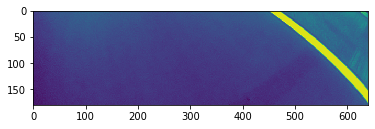

In [28]:
plt.imshow(I)
print(peaks)

In [18]:

peaks = p[0]

line_left   = None
line_right  = None
peaks_left  = peaks[peaks < CAMERA_CENTER]
peaks_right = peaks[peaks > CAMERA_CENTER]

if peaks_left.size:
    line_left = peaks_left.max()
    
if peaks_right.size:
    line_right = peaks_right.min()
    
p

(array([], dtype=int32), {'peak_heights': array([], dtype=float64)})

In [19]:
L = I[200, :]
b, a = butter(3, 0.1)
Lf = filtfilt(b, a, L)

plt.plot(L)
plt.plot(Lf)

IndexError: index 200 is out of bounds for axis 0 with size 180

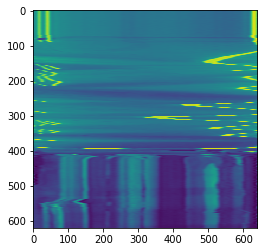

In [20]:
plt.imshow(np.vstack(history))